In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline



#Este codigo foi para remover o warning 
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

In [22]:
df = pd.read_csv('Dow Jones Iron & Steel Historical Data.csv')
df = df[['Date', 'Price']].dropna()

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

daily_df = df.resample('D').mean()
d_df = daily_df.reset_index().dropna()

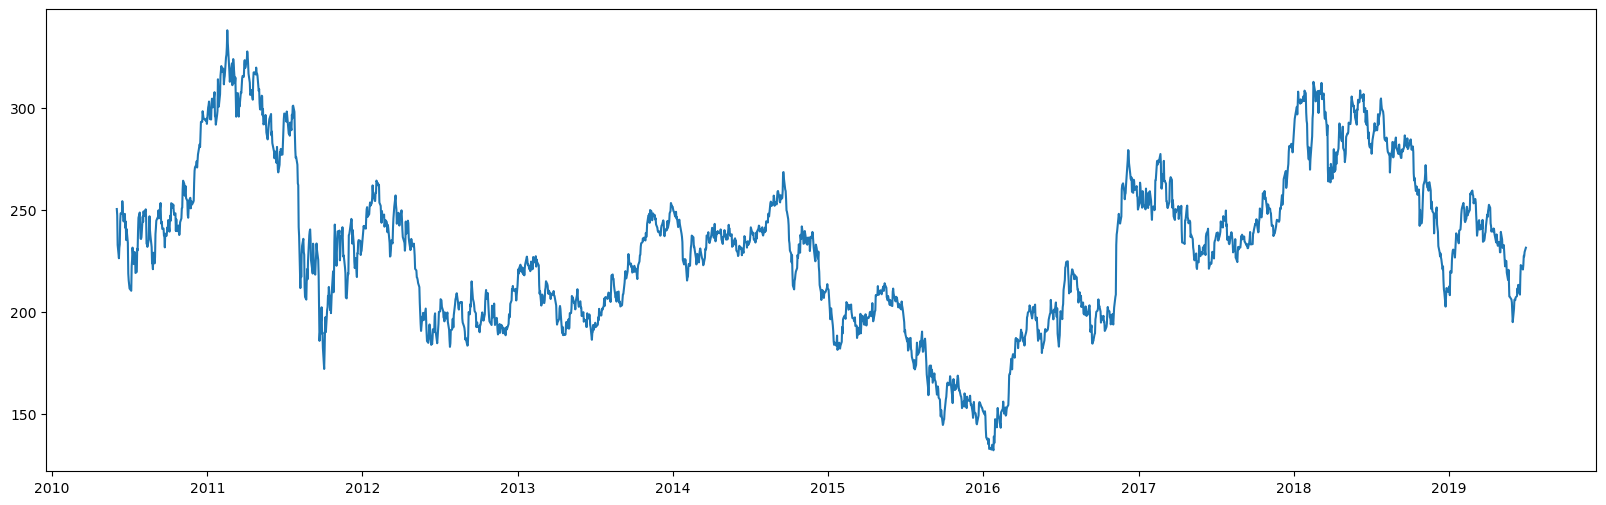

In [23]:
d_df.columns = ['ds', 'y']

fig = plt.figure(facecolor='w', figsize=(20, 6))
plt.plot(d_df.ds, d_df.y)

In [24]:
m = Prophet()
m.fit(d_df)

future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2372,2019-09-25,230.742897,206.917801,255.567513
2373,2019-09-26,230.381025,206.803070,255.358789
2374,2019-09-27,229.707430,204.804199,253.091033
2375,2019-09-28,237.661161,213.238903,262.267149
2376,2019-09-29,237.205365,212.417277,260.927619


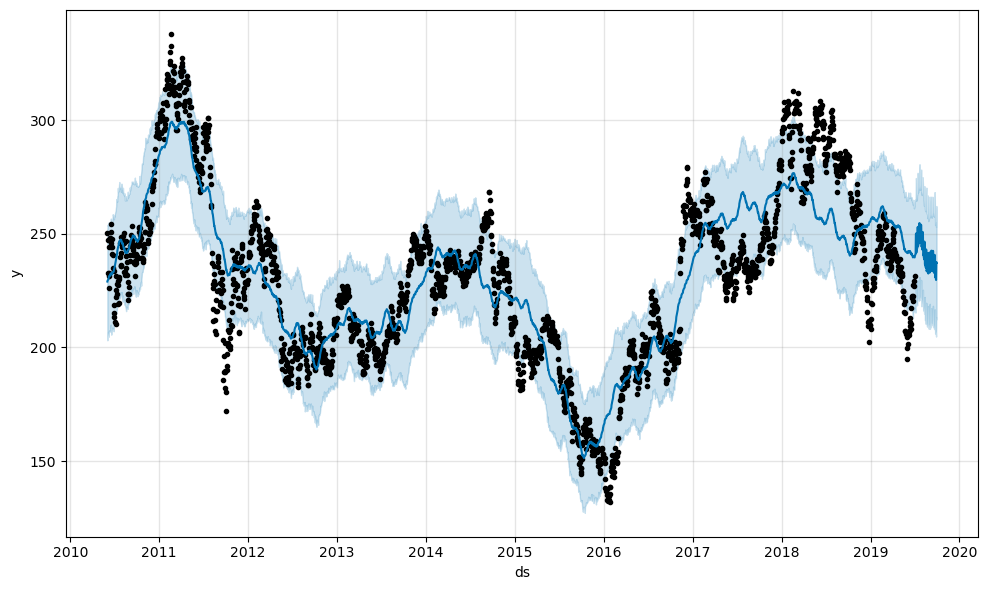

In [25]:
fig1 = m.plot(forecast)

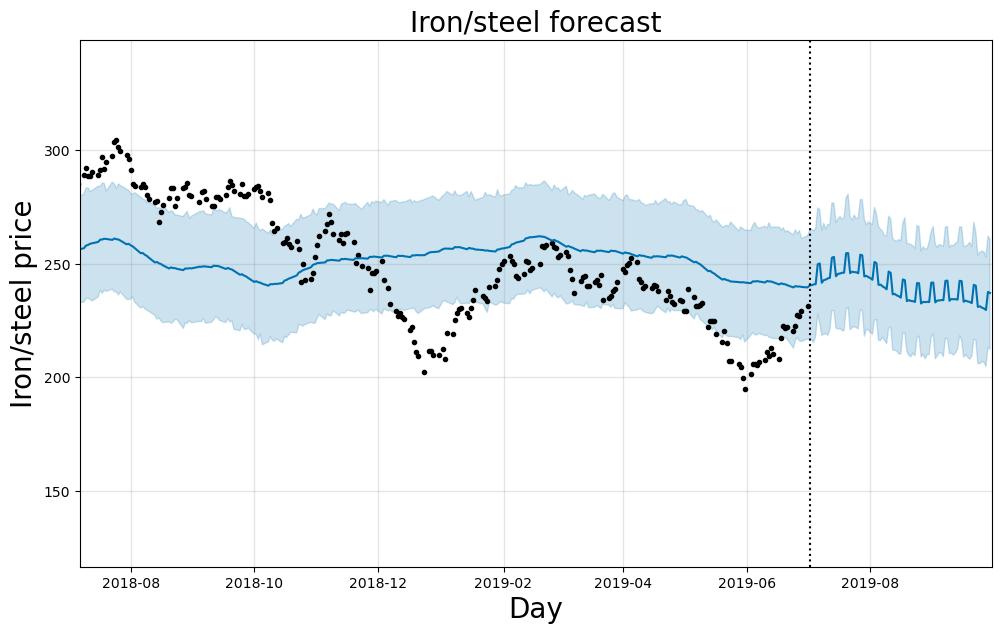

In [26]:
from datetime import datetime, timedelta

fig1 = m.plot(forecast)

#datenow = datetime.now()
datenow = datetime(2019, 7, 2)
dateend = datenow + timedelta(days=90)
datestart = dateend - timedelta(days=450)

plt.xlim([datestart, dateend])
plt.title("Iron/steel forecast", fontsize=20)
plt.xlabel("Day", fontsize=20)
plt.ylabel("Iron/steel price", fontsize=20)
plt.axvline(datenow, color="k", linestyle=":")
plt.show()

In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-90:]

,ds,yhat,yhat_lower,yhat_upper
2287,2019-07-02,240.533207,217.143588,264.625981
2288,2019-07-03,240.612995,216.737183,265.208512
2289,2019-07-04,240.982457,215.358758,264.568988
2290,2019-07-05,241.082394,218.160549,265.558681
2291,2019-07-06,249.841021,227.960805,274.591938
...,...,...,...,...
2372,2019-09-25,230.742897,206.917801,255.567513
2373,2019-09-26,230.381025,206.803070,255.358789
2374,2019-09-27,229.707430,204.804199,253.091033
2375,2019-09-28,237.661161,213.238903,262.267149


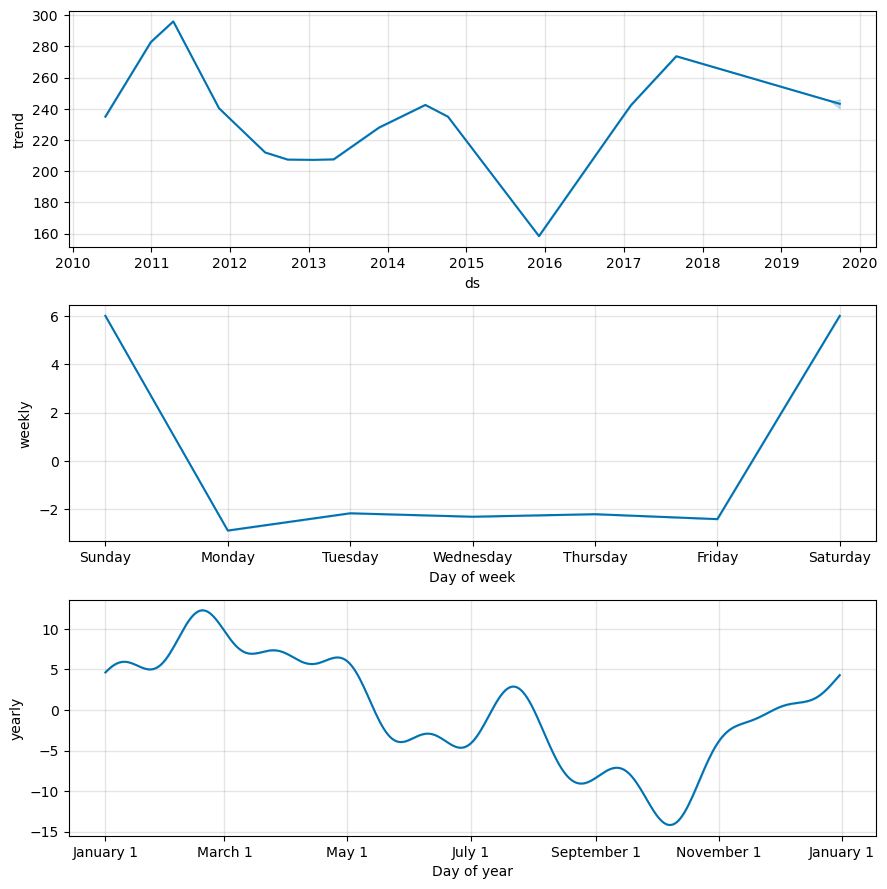

In [28]:
fig2 = m.plot_components(forecast)

In [29]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='90 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

  0%|          | 0/64 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,702.488677,26.504503,20.997825,0.094846,0.078987,0.094804,0.453199
1,10 days,734.411868,27.100034,21.464051,0.096923,0.082398,0.096852,0.444805
2,11 days,744.466873,27.284920,21.642638,0.097948,0.082933,0.098082,0.449495
3,12 days,761.120281,27.588408,21.940927,0.099254,0.083708,0.099459,0.437045
4,13 days,789.070848,28.090405,22.360261,0.100829,0.083552,0.100777,0.430976


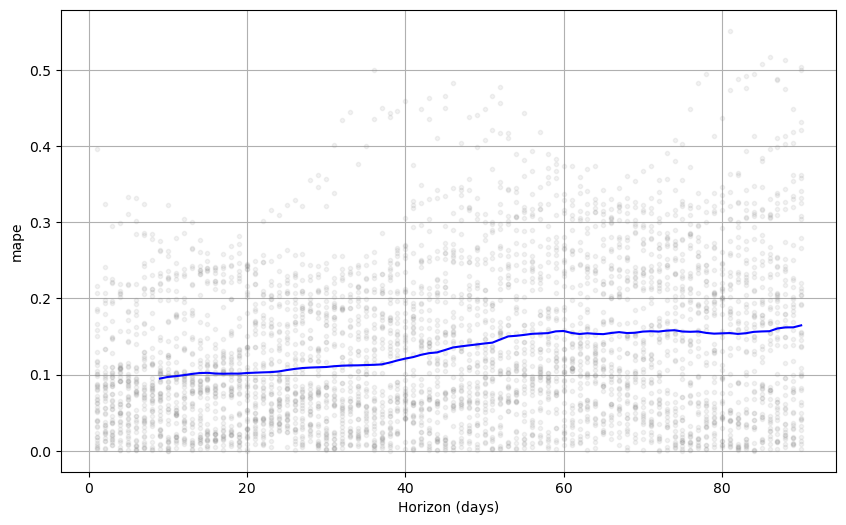

In [30]:
from prophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')

In [31]:
import pickle
with open('forecast_model.pckl', 'wb') as fout:
    pickle.dump(m, fout)

with open('forecast_model.pckl', 'rb') as fin:
    m2 = pickle.load(fin)

In [32]:
future2 = m2.make_future_dataframe(periods=90)
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2372,2019-09-25,230.742897,207.397389,253.048856
2373,2019-09-26,230.381025,206.410684,254.709364
2374,2019-09-27,229.707430,205.359705,254.488794
2375,2019-09-28,237.661161,215.117620,260.155129
2376,2019-09-29,237.205365,212.157244,260.366707


In [34]:
from flask import Flask, jsonify, request
from flask_cors import CORS, cross_origin

In [ ]:
app = Flask(__name__)
CORS(app)

@app.route("/katana-ml/api/v1.0/forecast/ironsteel", methods=['POST'])
def predict():
    horizon = int(request.json['horizon'])
    
    future2 = m2.make_future_dataframe(periods=horizon)
    forecast2 = m2.predict(future2)
    
    data = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-horizon:]
    
    ret = data.to_json(orient='records', date_format='iso')
    
    return ret

# running REST interface, port=3000 for direct test
if __name__ == "__main__":
    app.run(debug=False, host='0.0.0.0', port=3000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:3000
 * Running on http://192.168.68.106:3000
Press CTRL+C to quit
